## Scraping and Cleaning Tweets
The twitter API infuriatingly does not let you pull tweets more than a week old.  As such, I've had to use a combination of the [GetOldTweets library](https://pypi.org/project/GetOldTweets3/) and then Tweepy to extract the biography data. As such, this does need access to the Twitter API and a developer account (though I found that quite easy to get).

In [2]:
pip install GetOldTweets3

In [3]:
import tweepy
import logging
import GetOldTweets3 as got
import pandas as pd


API_KEY = "xx"
API_SECRET = "xx"
ACCESS_TOKEN = "xx"
ACCESS_TOKEN_SECRET ="xx"

auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

from tweepy import API


user_name = "@metpoliceuk"
q='to:{}'.format(user_name)


replies = api.search(q=q)

In this case, I've put together a query that pulls all tweets directed to the MPS username between set dates.  I'd warn that even using GetOldTweets, pull too many tweets at once and Twitter will kick you out - I found that especially during especially active social media days, I had to add a delay to my code.

In [4]:
tweetCriteria = got.manager.TweetCriteria().setQuerySearch(q)\
                                           .setSince("2020-08-24")\
                                           .setUntil("2020-08-25")
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

df = pd.DataFrame(tweets)

def get_text(tweet):
  return tweet.text

def get_username(tweet):
  return tweet.username

df["username"] = df[0].apply(get_username)
df["text"] = df[0].apply(get_text)

bios_df = df.copy()
bios = bios_df.dropna(axis=0, subset=["username"])

list_of_bios = bios["username"].tolist()

def get_bio(user):
  list_of_bios = pd.DataFrame(columns=["Users","Bios"])
  i = 100
  while i < len(user):
    users = user[i-100:i]
    test = api.lookup_users(screen_names =users)
    for person in test:
      list_of_bios = list_of_bios.append({'Users' : person.screen_name , 'Bios' : person.description}, ignore_index=True)
    i = i + 100
  users = user[i-100:len(user)]
  test = api.lookup_users(screen_names =users)
  for person in test:
      list_of_bios = list_of_bios.append({'Users' : person.screen_name , 'Bios' : person.description}, ignore_index=True)
  return list_of_bios
 
list_of_new_bios = get_bio(df["username"].tolist())

list_of_new_bios["username"] = list_of_new_bios["Users"]
df_with_bio = df.merge(list_of_new_bios, on="username")
df_with_bio = df_with_bio.rename(columns={"Bios":"bio"})
df_with_bio = df_with_bio.drop("Users",axis=1)

With that all done, you can pull out a list of all your tweets that day, as well a the userbiography.  

In [6]:
df_with_bio

,0,username,text,bio
0,<GetOldTweets3.models.Tweet.Tweet object at 0x...,ClintClease,He’s got smug look on his face. A creature lik...,"Author, Designer, Composer, Photographer, Anti..."
1,<GetOldTweets3.models.Tweet.Tweet object at 0x...,Listhebest2020,London is safe huh?! Judging by the majority o...,Nobody you know. #NLF #TheKLF and #KBF. RTs ar...
2,<GetOldTweets3.models.Tweet.Tweet object at 0x...,repentandtrust,@metpoliceuk @UKParliament why are you still a...,✝️ Christian\n✝️ Defending Christianity agains...
3,<GetOldTweets3.models.Tweet.Tweet object at 0x...,hoxtonist,"If you killed someone driving a car, you reall...",
4,<GetOldTweets3.models.Tweet.Tweet object at 0x...,joepublic99,@metpoliceuk @UKSupremeCourt @TheFCA @LibDems ...,True Social Justice ¦ Thriving Fair Economy ¦ ...
...,...,...,...,...
175,<GetOldTweets3.models.Tweet.Tweet object at 0x...,MornnigGlory,@metpoliceuk #metpoliceuk,Self-Made man - confident reliable honest cari...
176,<GetOldTweets3.models.Tweet.Tweet object at 0x...,MatthewFahey15,"Um, not to sure what to say other than that's ...","Disability rights advocate, Supporter of the a..."
177,<GetOldTweets3.models.Tweet.Tweet object at 0x...,AlfredWintle,"London isn’t safe so stop virtue signalling, s...","Western virtues such as democracy, free speech..."
178,<GetOldTweets3.models.Tweet.Tweet object at 0x...,PatriciaRickey2,But BLM riots allowed to happen,


## Coding and Learning
This is the painful bit: I had to manually go through a few hundred tweets and manually label them as "Right Wing" or not based on my own hunches.  

I went with the below


*   Anti-immigration sentiment
*   Anti-socialism/BLM
*   Pro-Brexit/Anti-EU
*   Pro-Trump/MAGA

The coded set can be found below.




In [8]:
import pandas as pd
from fastai.text.all import *


In [10]:
training = pd.read_csv("/content/drive/My Drive/data/sentiment training set.csv")
training

,username,bio,RW,is_valid
0,RichardSTOCKDA4,RUGBY LOVING EX PLAYER NOW ONE OF THE PROUD RVS/NHS VOLUNTEERING TEAM ACTIVELY SEEKING OUT/EXPOSING GROOMING GANG MEMBERS,1,1
1,cold957,#Veteran. 1st Bn Coldstream Guards/Guards Para.\nWe can forgive a child who is afraid of the dark. The real tragedy of life is when men fear the light.\nNO DMs.,1,1
2,leftwant2brite,"Be aware of leftwing politics, Jihadists & militant Communists like those in ANTIFA. fascism is totalitarianism born from socialism. It's also an economic syst🧐",1,1
3,HermioneMidwife,"Digital Midwife at the RCM and King’s College Hospital. Women centred, clinically led, digitally driven. FNF Scholar",0,1
4,scoutingfamily,Professional Football Scout & Player Recruitment Specialist \n@england @stokecity \nEngland U17 World Cup Winners 🏆🥇,0,1
...,...,...,...,...
502,AlfredWintle,"Western virtues such as democracy, free speech, equal & human rights need to be preserved & protected before it’s too late. Love Europe & therefore hate the EU.",1,1
503,Me1Chri,"Journalist forever (I care, write, edit, design, research and study, cook, volunteer). Project Editor. Kingston University, London.",0,1
504,UK Cop Humour,Simply trying to show the human side of our fantastic Police Officers & raise a bit of money for good causes whilst we're at it! RT's are not an endorsement.,0,1
505,CopThatCooks,"Detective with \n@WMerciaPolice\n working in #Worcester CID . Also tweeting as \n@HistoryCop\n. Here to engage, explain and encourage.",0,1


FastAI includes the very convenient concept of a "DataLoader": a python object that combines all the data you're working with, split into a training and test set, in a format it can work with. 

For text classication, that object does a lot of the heavy lifting for you. NLP normally requires an awful lot of data-cleaning: you break your text into words, then add special characters to capitalisation, sentence starts, etc. As you can see below, FastAI has done *all of that* in a few lines of code. The down-side is, I'm not hugely clear exactly what it's done, or how I can now read my text.

In [11]:
training = training.dropna(axis=0)
training["RW"] = training["RW"].astype("boolean")
training["is_valid"] = training["is_valid"].astype("boolean")
dls = TextDataLoaders.from_df(training, text_col = "bio", label_col="RW")
dls.show_batch()

,text,category
0,"xxbos xxmaj xxunk xxmaj united , xxmaj welsh xxmaj rugby , xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj xxunk , xxmaj the xxmaj xxunk , xxmaj small xxmaj xxunk , xxmaj the xxmaj who , xxmaj the xxmaj xxunk , xxmaj the xxmaj xxunk , xxmaj xxunk , xxmaj xxunk + xxmaj the xxmaj xxunk",False
1,"xxbos xxmaj ex xxunk . xxmaj xxunk . xxmaj xxunk living in xxmaj london . xxmaj england great . xxmaj dislike xxup xxunk . \n\n ( xxunk : xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk , xxup xxunk , & xxunk ) \n ( small : xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxup xxunk ) xxpad xxpad xxpad xxpad xxpad",False
2,"xxbos xxmaj peace , i am xxmaj xxunk , \n xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk \n xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk \n xxmaj follow xxmaj me xxmaj for xxmaj follow xxmaj back \n xxmaj retweet xxmaj me xxmaj for xxmaj follow xxmaj back \n xxmaj xxunk xxmaj love xxpad xxpad xxpad xxpad xxpad xxpad",False
3,"xxbos xxmaj loves xxmaj xxunk , xxmaj cats , xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj the xxmaj xxunk , \n xxmaj xxunk & xxmaj xxunk . \n xxmaj art xxunk xxunk - https : / / t.co / xxunk 🙏 xxpad xxpad xxpad xxpad xxpad xxpad",False
4,"xxbos xxmaj xxunk me know when the xxunk xxunk , \n xxmaj no xxmaj xxunk xxmaj brexit \n xxmaj if its on the xxup bbc its not true , \n▁ # defundthebbc \n▁ # xxup maga , # xxup mbga , # xxunk , # xxunk \n i xxunk not xxunk of xxmaj xxunk , xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False
5,"xxbos xxmaj love my xxunk xxmaj xxunk fc , xxmaj football , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk and xxmaj xxunk . xxmaj but i love nothing more than my family and xxmaj xxunk xxmaj xxunk xxunk ️ # xxup lfc # xxup xxunk # xxup ynwa \n\n xxmaj xxunk - xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False
6,"xxbos xxmaj xxunk . xxup xxunk xxmaj member . xxup xxunk xxmaj member , xxmaj xxunk xxrep 3 i xxmaj member , xxmaj xxunk xxmaj member , xxmaj xxunk not xxmaj xxunk , # xxup xxunk , # xxup xxunk , # xxup xxunk , # xxup xxunk , 🇬 🇧 🇨 xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False
7,"xxbos xxmaj xxunk xxmaj west xxunk live for xxunk xxunk . xxmaj xxunk xxmaj xxunk xxmaj xxunk , hate xxmaj london xxmaj xxunk . xxmaj still a xxup xxunk xxunk block xxunk . xxunk ️ # xxup xxunk # xxmaj xxunk xxrep 3 xxunk # xxunk # xxmaj brexit # xxmaj england xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False
8,xxbos # xxmaj xxunk . 1st xxmaj xxunk xxmaj xxunk xxmaj xxunk / xxmaj xxunk xxmaj xxunk . \n xxmaj we can xxunk a xxunk who is afraid of the xxunk . xxmaj the real xxunk of life is when men fear the light . \n xxup no dms . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,True


This is the fun bit: learning. Notice hear we aren't starting from scracth: we call the "fine_tune" function, because fastAI already contains a model trained on text.

In [12]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.881830,0.655739,0.861386,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.825345,0.595676,0.851485,00:34
1,0.796265,0.541380,0.891089,00:29
2,0.784324,0.509539,0.881188,00:28
3,0.764621,0.497642,0.871287,00:30
4,0.742817,0.503554,0.801980,00:29


In [13]:
learn.show_results()

,text,category,category_
0,"xxbos xxmaj xxunk xxmaj of # xxunk xxmaj with xxmaj old # xxup xxunk xxmaj xxunk / s , & # xxup xxunk / # xxup xxunk , u xxup must xxup be xxunk + xxunk xxup me . xxup i 'm xxup open & xxup xxunk xxup about xxup my # xxup xxunk , # xxup xxunk , & xxup life xxunk # xxup xxunk",False,False
1,"xxbos xxmaj bye xxmaj bye xxup eu xxunk xxmaj xxunk so xxunk xxmaj i xxunk only xxunk % xxmaj english with xxunk % xxmaj welsh , xxmaj irish , xxmaj xxunk + little bit of xxmaj xxunk . that ’ll be the xxmaj xxunk side . xxmaj xxunk ; i xxunk back ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",True,True
2,xxbos xxmaj xxunk 1 xxmaj xxunk since ' xxunk ; xxup xxunk xxmaj football xxmaj referee ; xxup xxunk xxmaj referee xxmaj xxunk ; xxup xxunk ; xxmaj xxunk - time xxmaj xxunk & xxmaj xxunk xxmaj xxunk . i may xxunk with you but will never xxunk you ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,False,False
3,"xxbos xxmaj xxunk , the xxunk , xxunk xxunk . xxmaj xxunk xxmaj xxunk . ' i do n't agree xxunk / what u have 2 say , but xxmaj i 'll xxunk 2 xxunk xxunk right 2 say it . ' xxmaj xxunk xxmaj xxunk xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False,False
4,xxbos xxmaj xxunk up with xxmaj all the xxmaj politicians xxunk to us . \n xxunk \n xxmaj do nt xxunk me off about xxmaj snowflakes of the world . \n\n xxmaj xxunk when xxmaj i 'm out xxunk my bike xxunk or walking my dog 🐶 xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,False,False
5,"xxbos xxmaj xxunk with xxup me / xxmaj xxunk 20 xxunk . xxmaj loves - xxmaj xxunk ( my xxunk ) xxunk xxmaj my xxunk , mum , xxunk family . xxmaj dogs ( more than people ! ) 🐶 \n xxmaj xxunk / xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False,False
6,"xxbos xxmaj xxunk for xxmaj xxunk , xxmaj xxunk of xxmaj xxunk xxmaj xxunk xxmaj trust . xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj face xxmaj uk , xxmaj supports our xxmaj armed xxmaj forces and our xxmaj emergency services . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",True,False
7,"xxbos xxmaj xxunk in xxmaj xxunk xxmaj xxunk . xxmaj first xxmaj xxunk xxunk xxunk from xxmaj xxunk . xxmaj xxunk xxunk xxmaj may 1st xxunk . xxunk xxmaj xxunk to xxmaj prem , back to xxunk , back to xxmaj prem in xxunk years ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",False,False
8,xxbos xxmaj xxunk . xxmaj author . xxmaj xxunk with the xxunk from xxmaj xxunk . xxmaj xxunk . xxmaj retweet / follow does n't xxunk xxunk - i use xxunk a lot . xxmaj xxunk but not xxmaj xxunk . xxup xxunk . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,False,False


Now, we can start predicting! FastAI will take any bundle of text and tell you whether it thinks it's right wing or not (based on my coding).  If I'm entirely honest, this doesn't work fantastically - it seems to have decided that the phrase "Justice for" is essentially a right wing calling card, which I'm not entirely comfortable with.  That said, the process works!  Ish.  

In [19]:
learn.predict("Justice for our Brexit")

('True', tensor(1), tensor([0.3523, 0.6477]))

In [17]:
learn.predict("Hate snowflakes, socialists, and the EU")

('True', tensor(1), tensor([0.2483, 0.7517]))

In [20]:
learn.predict("I love puppies and stuff")

('False', tensor(0), tensor([0.5286, 0.4714]))

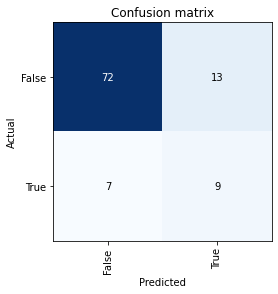

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## The Prototype
So, can we convert all this into a working application?  Sure!  Ish. My combining my tweet extractor with sentiment analysis of the tweet text itself (I found [this medium blog post](https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082) very helpful) we can analyse for any specific day, the volume of tweets flagged as "right wing", and contrast them to the overall messaging, and compare their "Subjectivity (how subjective or opinionated the text is — a score of 0 is fact, and a score of +1 is very much an opinion) and the other to get the tweets called Polarity (how positive or negative the text is, — score of -1 is the highest negative score, and a score of +1 is the highest positive score)".

While I would have loved to deploy this to Heroku or Binder using Voila, the Pytorch text classification model annoying takes far over 500mb of space, so neither free option will support it - it does look like you can chose to use the CPU pytorch option instead, but frankly it's painful to get the implementation working! 

### Helper Functions
We start by bringing together all my previous code (as well as some rough sentiment analysis of the text itself) into one chunk, then added widgets.

In [31]:
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.express as px

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import *

In [32]:
import tweepy
import logging
from tweepy import API

auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

learn_inf = learn

#Tweet cleaning helper function
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
 return text

#helper function that pulls the biography of a username using the Twitter api
def get_bio(user):
  list_of_bios = pd.DataFrame(columns=["Users","Bios"])
  i = 100
  while i < len(user):
    users = user[i-100:i]
    test = api.lookup_users(screen_names =users)
    for person in test:
      list_of_bios = list_of_bios.append({'Users' : person.screen_name , 'Bios' : person.description}, ignore_index=True)
    i = i + 100
  users = user[i-100:len(user)]
  test = api.lookup_users(screen_names =users)
  for person in test:
      list_of_bios = list_of_bios.append({'Users' : person.screen_name , 'Bios' : person.description}, ignore_index=True)
  return list_of_bios


def get_label(row):
  return row[0]

def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
 return text


list_of_new_bios = get_bio(df["username"].tolist())

In [33]:
def run_process(user_name, date_from, date_to):

  q='to:{}'.format(user_name)

  tweetCriteria = got.manager.TweetCriteria().setQuerySearch(q)\
                                            .setSince(date_from)\
                                            .setUntil(date_to)
  tweets = got.manager.TweetManager.getTweets(tweetCriteria)

  df = pd.DataFrame(tweets)

  def get_text(tweet):
    return tweet.text

  def get_username(tweet):
    return tweet.username

  df["username"] = df[0].apply(get_username)
  df["text"] = df[0].apply(get_text)

  bios_df = df.copy()
  bios = bios_df.dropna(axis=0, subset=["username"])
  bios = bios.drop_duplicates(subset=["username"])

  auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
  auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

  api = tweepy.API(auth)

  list_of_new_bios = get_bio(df["username"].tolist())

  list_of_new_bios["RW_prediction"] = list_of_new_bios["Bios"].apply(learn_inf.predict)

  list_of_new_bios["RW_prediction"] = list_of_new_bios["RW_prediction"].apply(get_label)

  list_of_new_bios = list_of_new_bios.rename({"Users":"username"}, axis=1)

  new_df = df.merge(list_of_new_bios, on=["username"])



  # Clean the tweets
  new_df['clean_text'] = new_df['text'].apply(cleanTxt)

    # Create two new columns 'Subjectivity' & 'Polarity'
  new_df['Subjectivity'] = new_df['clean_text'].apply(getSubjectivity)
  new_df['Polarity'] = new_df['clean_text'].apply(getPolarity)

  right_wing_mask = new_df["RW_prediction"] == "True"
  right_wing = new_df[right_wing_mask]

  not_right_wing_mask = new_df["RW_prediction"] == "False"
  not_right_wing = new_df[not_right_wing_mask]

  fig2 = px.scatter(new_df, x="Subjectivity", y="Polarity", color="RW_prediction", trendline="ols", hover_data=["Bios"])
  fig2.update_xaxes(range=[-0.1,1.1])
  fig2.update_yaxes(range=[-1.1, 1.1])

  grouped_by_RW = new_df.groupby("RW_prediction").agg(
    count= ("text", len),
    Subjectivity = ("Subjectivity", np.mean),
    Polarity = ("Polarity", np.mean))
  
  fig1 = px.bar(grouped_by_RW, y="count", color=grouped_by_RW.index)

  final = round(grouped_by_RW["count"].iloc[1] / grouped_by_RW["count"].iloc[0],3) * 100

  return grouped_by_RW, fig1, fig2, final

In [34]:
username_select =widgets.Text(
    value='@metpoliceuk',
    placeholder='Type something',
    description='Username:',
    disabled=False
)

date_from_widget =widgets.Text(
    value='2020-08-27',
    placeholder='Type something',
    description='Date From:',
    disabled=False
)

date_to_widget =widgets.Text(
    value='2020-08-28',
    placeholder='Type something',
    description='Date To:',
    disabled=False
)

def show_graph2(change):
  with out_df:
    print("analysing..")
  results = run_process(username_select.value, date_from_widget.value, date_to_widget.value)
  out_df.clear_output()
  out_analysis.clear_output()
  out_graph1.clear_output()
  out_graph2.clear_output()
  with out_df:
    print(str(results[3]) + "% RW interactions")
  with out_analysis:
    print(results[0])
  with out_graph1:
    results[1].show()
  with out_graph2:
    results[2].show()
  
analyse_button = widgets.Button(description='Analyse')

analyse_button.on_click(show_graph2)

out_df = widgets.Output(layout={'border': '1px solid black'})
out_analysis = widgets.Output(layout={'border': '1px solid black'})
out_graph1 = widgets.Output(layout={'border': '1px solid black'})
out_graph2 = widgets.Output(layout={'border': '1px solid black'})


### The Product
Finally, my working product - given a user-name and two dates, it will pull all tweets on those dates, run the sentiment analysis, show the ratio of right-wing tweets, and the sentiment on those. Here I've specifically picked the day Dawn Butler was stopped by police, and notice how right wing 

In [37]:
'''VBox([widgets.Label('Tweet Monitor'),
      username_select, date_from_widget, date_to_widget, analyse_button, out_df, out_analysis, out_graph1, out_graph2])'''

"VBox([widgets.Label('Tweet Monitor'),\n      username_select, date_from_widget, date_to_widget, analyse_button, out_df, out_analysis, out_graph1, out_graph2])"

In [146]:
def run_process_2(user_name, date_from, date_to):

  q='to:{}'.format(user_name)

  tweetCriteria = got.manager.TweetCriteria().setQuerySearch(q)\
                                            .setSince(date_from)\
                                            .setUntil(date_to)
  tweets = got.manager.TweetManager.getTweets(tweetCriteria)

  df = pd.DataFrame(tweets)

  def get_text(tweet):
    return tweet.text

  def get_username(tweet):
    return tweet.username

  df["username"] = df[0].apply(get_username)
  df["text"] = df[0].apply(get_text)

  bios_df = df.copy()
  bios = bios_df.dropna(axis=0, subset=["username"])
  bios = bios.drop_duplicates(subset=["username"])

  auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
  auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

  api = tweepy.API(auth)

  list_of_new_bios = get_bio(df["username"].tolist())

  list_of_new_bios["RW_prediction"] = list_of_new_bios["Bios"].apply(learn_inf.predict)

  list_of_new_bios["RW_prediction"] = list_of_new_bios["RW_prediction"].apply(get_label)

  list_of_new_bios = list_of_new_bios.rename({"Users":"username"}, axis=1)

  new_df = df.merge(list_of_new_bios, on=["username"])



  # Clean the tweets
  new_df['clean_text'] = new_df['text'].apply(cleanTxt)

    # Create two new columns 'Subjectivity' & 'Polarity'
  new_df['Subjectivity'] = new_df['clean_text'].apply(getSubjectivity)
  new_df['Polarity'] = new_df['clean_text'].apply(getPolarity)

  right_wing_mask = new_df["RW_prediction"] == "True"
  right_wing = new_df[right_wing_mask]

  not_right_wing_mask = new_df["RW_prediction"] == "False"
  not_right_wing = new_df[not_right_wing_mask]

  fig2 = px.scatter(new_df, x="Subjectivity", y="Polarity", color="RW_prediction", trendline="ols", hover_data=["Bios"])
  fig2.update_xaxes(range=[-0.1,1.1])
  fig2.update_yaxes(range=[-1.1, 1.1])

  import seaborn as sns; sns.set()
  fig2 = sns.jointplot(new_df["Polarity"], new_df["Subjectivity"], kind="hex", height=7, space=0)
  fig2.fig.subplots_adjust(top=0.9)
  fig2.fig.suptitle("All Tweets")
  #fig2.set(xlim=(-1,1),ylim=(0,1))


  grouped_by_RW = new_df.groupby("RW_prediction").agg(
    count= ("text", len),
    Subjectivity = ("Subjectivity", np.mean),
    Polarity = ("Polarity", np.mean))
  
  fig1 = sns.jointplot(right_wing["Polarity"], right_wing["Subjectivity"], kind="hex", height=7, space=0)
  fig1.fig.subplots_adjust(top=0.9)
  fig1.fig.suptitle("Right Wing Tweets")
  #fig1.set(xlim=(-1,1),ylim=(0,1))

  final = round(grouped_by_RW["count"].iloc[1] / grouped_by_RW["count"].iloc[0],3) * 100

  return final, fig1.fig, fig2.fig

In [153]:
#final, fig1, fig2 = run_process_2("@MetPoliceUK", "2020-08-09","2020-08-10")

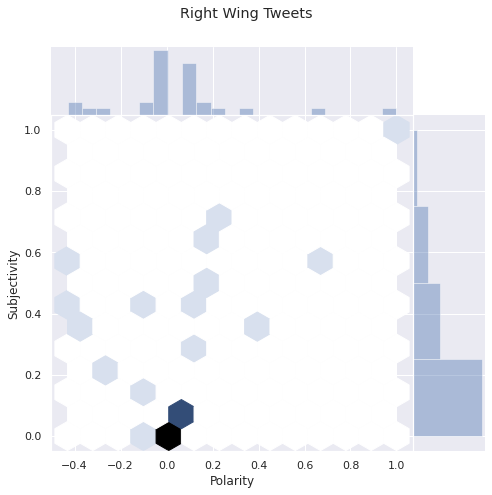

In [148]:
fig1


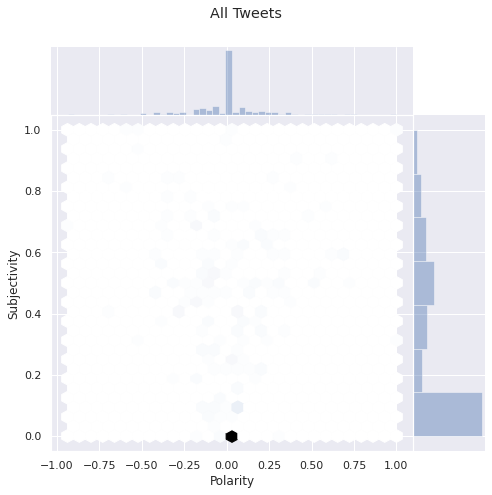

In [149]:
fig2

In [154]:
#final, fig1, fig2 = run_process_2("@OwenJones84", "2020-08-09","2020-08-10")

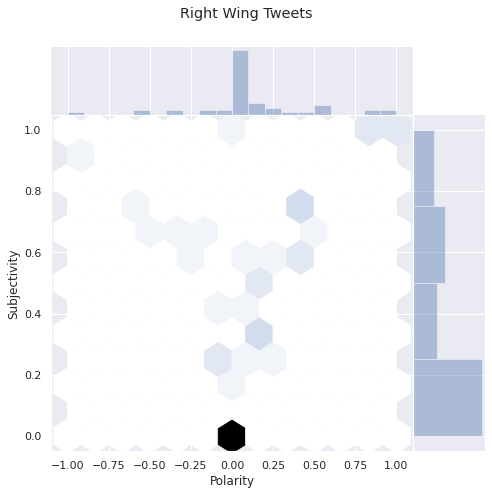

In [151]:
fig1


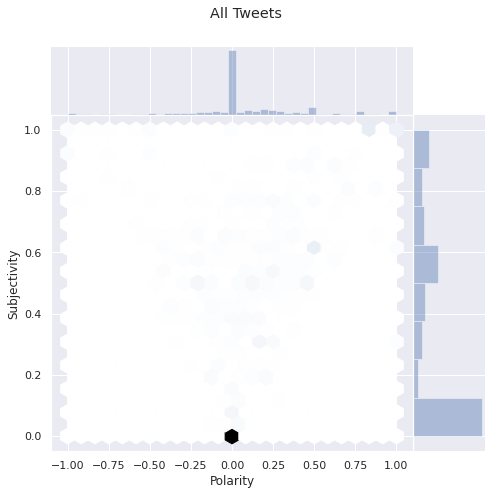

In [152]:
fig2